# Analysis of My Music/Health Data

## Imports & configurations

In [306]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import garminconnect
from datetime import timedelta
from lyricsgenius import Genius
from dotenv import load_dotenv
from tqdm import tqdm
from transformers import pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

pd.options.display.max_columns = 200
tqdm.pandas()

load_dotenv()

True

## Read in Spotify data

In [307]:
df = pd.read_json('./spotify_data/Streaming_History_Audio_2024_29.json')
df.head()

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,audiobook_title,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2024-06-25T11:58:46Z,ios,132060,US,2601:14d:4b84:4a70:713f:c9ce:309c:32b9,Almost Fantasy,Fog Lake,Almost Fantasy,spotify:track:30U7MwsSebniOJyZ8y1hcE,None,None,None,NaN,NaN,NaN,NaN,trackdone,trackdone,True,False,False,1719316594,False
1,2024-06-25T12:01:20Z,ios,152571,US,166.199.139.64,High,Slow Pulp,Big Day,spotify:track:3GaamyFHQYbQi1ykc4nV4o,None,None,None,NaN,NaN,NaN,NaN,trackdone,trackdone,True,False,False,1719316726,False
2,2024-06-25T12:02:04Z,ios,42733,US,166.199.139.64,From the Subway Train,Vansire,Angel Youth,spotify:track:0qOCy2LqvdkMora7eZsJhQ,None,None,None,NaN,NaN,NaN,NaN,trackdone,endplay,True,True,False,1719316880,False
3,2024-06-25T12:05:30Z,ios,205554,US,166.199.139.64,I Hope to Be Around,Men I Trust,I Hope to Be Around,spotify:track:3xnM0WCRJKk4Iz49rkG5OC,None,None,None,NaN,NaN,NaN,NaN,clickrow,trackdone,False,False,False,1719316924,False
4,2024-06-25T12:09:17Z,ios,227426,US,166.199.139.64,Your face,Wisp,Your face,spotify:track:7ne2hzW4jaU5tacaCI4kJH,None,None,None,NaN,NaN,NaN,NaN,trackdone,trackdone,True,False,False,1719317130,False


## Drop, rename, and changes dtypes

In [308]:
# Filter out songs listened to for < 1 minute
df = df[df['ms_played'] > 60000]

# Drop and rename columns
df = df[['ts', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name']]
df = df.rename(columns={'ts': 'date', 'master_metadata_track_name': 'track', 'master_metadata_album_artist_name': 'artist', 'master_metadata_album_album_name': 'album'})

# Drop missing values and changes dtypes
df.dropna(subset=["track"], inplace=True)
df['date'] = pd.to_datetime(df['date']).dt.date
df.reset_index(drop=True, inplace=True)
df.head()

,date,track,artist,album
0,2024-06-25,Almost Fantasy,Fog Lake,Almost Fantasy
1,2024-06-25,High,Slow Pulp,Big Day
2,2024-06-25,I Hope to Be Around,Men I Trust,I Hope to Be Around
3,2024-06-25,Your face,Wisp,Your face
4,2024-06-25,Sour Switchblade,Elita,Sour Switchblade


## Get song lyrics with Genius API

In [309]:
saved_lyrics = {}

def get_lyrics(row):
    if row['track'] in saved_lyrics:
        return saved_lyrics[row['track']]
    else:
        song = None
        try:
            song = genius.search_song(row['track'], row['artist'])
            saved_lyrics[row['track']] = song.lyrics if song else None
            time.sleep(1)
        except:
            saved_lyrics[row['track']] = None
            time.sleep(10)

        return song.lyrics if song else None

genius = Genius(os.getenv('GENIUS_TOKEN'), verbose=True, remove_section_headers=True)
#df['lyrics'] = df.progress_apply(get_lyrics, axis=1)

## Copy dataframe as backup

In [310]:
df_copy = df.copy(deep=True)

## Restore dataframe from copy (if necessary)

In [311]:
#df = df_copy

In [312]:
lyric_df = pd.read_csv('lyrics.csv')
df['lyrics'] = lyric_df['lyrics']
df.head()

,date,track,artist,album,lyrics
0,2024-06-25,Almost Fantasy,Fog Lake,Almost Fantasy,6 ContributorsAlmost Fantasy LyricsAnd maybe I...
1,2024-06-25,High,Slow Pulp,Big Day,12 ContributorsHigh Lyrics\nI have too much in...
2,2024-06-25,I Hope to Be Around,Men I Trust,I Hope to Be Around,14 ContributorsI Hope to Be Around Lyrics\nI h...
3,2024-06-25,Your face,Wisp,Your face,25 ContributorsYour face Lyrics\nIs this all r...
4,2024-06-25,Sour Switchblade,Elita,Sour Switchblade,26 ContributorsTranslationsEspañolSour Switchb...


## Drop missing lyrics and remove extra characters

In [313]:
df.dropna(subset=["lyrics"], inplace=True)
df.reset_index(drop=True, inplace=True)

def slice_lyrics(row):
    """
    Removes extraneous characters from 'lyrics' column.
    """
    lyrics = row['lyrics']
    lyric_start = lyrics.find('Lyrics')
    read_more = lyrics.find('Read More')

    if read_more != -1:
        lyrics = lyrics[read_more+(len('Read More')):]
    elif lyric_start != -1:
        lyrics = lyrics[lyric_start+(len('Lyrics')):]
    
    lyrics = lyrics.replace("\n", " ")
    return lyrics

df['lyrics'] = df.apply(slice_lyrics, axis=1)

df.head()

,date,track,artist,album,lyrics
0,2024-06-25,Almost Fantasy,Fog Lake,Almost Fantasy,And maybe I found paradise A little empathy bu...
1,2024-06-25,High,Slow Pulp,Big Day,I have too much in my pockets I wish they wer...
2,2024-06-25,I Hope to Be Around,Men I Trust,I Hope to Be Around,I hope to be around The day we grasp in truth...
3,2024-06-25,Your face,Wisp,Your face,Is this all real? You're stuck in my head Dro...
4,2024-06-25,Sour Switchblade,Elita,Sour Switchblade,I wanna talk to you About the things we could...


## Perform sentiment analysis on lyrics

In [314]:
sa_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# SA model: distilbert-base-uncased-finetuned-sst-2-english
# Emotion model: j-hartmann/emotion-english-distilroberta-base

def sentiment_analysis(row):
    """
    Returns sentiment of lyrics.
    """
    lyrics = row['lyrics']
    if len(lyrics) > 500:
        lyrics = lyrics[:420]
    
    try:
        sentiment = sa_pipeline(lyrics)
        
        # Invert negative scores
        sentiment[0]['score'] = sentiment[0]['score'] * -1 if sentiment[0]['label'] == 'NEGATIVE' else sentiment[0]['score'] 
    except:
        sentiment = [{'score': None}]
    return sentiment[0]['score']

df['sentiment'] = df.apply(sentiment_analysis, axis=1)
df.head()

Device set to use mps:0


,date,track,artist,album,lyrics,sentiment
0,2024-06-25,Almost Fantasy,Fog Lake,Almost Fantasy,And maybe I found paradise A little empathy bu...,-0.985884
1,2024-06-25,High,Slow Pulp,Big Day,I have too much in my pockets I wish they wer...,-0.999434
2,2024-06-25,I Hope to Be Around,Men I Trust,I Hope to Be Around,I hope to be around The day we grasp in truth...,0.991754
3,2024-06-25,Your face,Wisp,Your face,Is this all real? You're stuck in my head Dro...,-0.540359
4,2024-06-25,Sour Switchblade,Elita,Sour Switchblade,I wanna talk to you About the things we could...,0.997637


## Get Garmin Data

In [315]:
# Log in to Garmin
garmin = garminconnect.Garmin(os.getenv('GARMIN_EMAIL'), os.getenv('GARMIN_PW'))
garmin.login()

# Get start/end dates from spotify dataframe
start_date = df['date'].min()
print(f'Start date: {start_date}')
end_date = df['date'].max()
print(f'End date: {end_date}')

# Iterate over relevant Spotify dates
rows = []
delta = timedelta(days=1)
while start_date <= end_date:
    stats = garmin.get_stats(start_date)
    row = [
            start_date, 
            int(stats['totalKilocalories']), 
            stats['totalSteps'], 
            round((stats['sleepingSeconds']/3600),2),
            round((stats['highlyActiveSeconds']/3600), 2),
            round((stats['activeSeconds']/3600), 2),
            round((stats['sedentarySeconds']/3600), 2),
            stats['minHeartRate'],
            stats['maxHeartRate'],
            stats['restingHeartRate'],
            stats['averageStressLevel'],
            stats['maxStressLevel']
           ]
    rows.append(row)
    start_date += delta

# Create Garmin dataframe
garmin_df = pd.DataFrame(rows)
garmin_df.columns = ['date', 'calories', 'steps', 'sleep_hours', 'highly_active_hours', 'active_hours',
                     'sedentary_hours', 'min_hr', 'max_hr', 'resting_hr', 'avg_stress', 'max_stress']
garmin_df.head()

Start date: 2024-06-25
End date: 2024-11-19


,date,calories,steps,sleep_hours,highly_active_hours,active_hours,sedentary_hours,min_hr,max_hr,resting_hr,avg_stress,max_stress
0,2024-06-25,2861,15188,7.45,1.32,2.25,12.98,33,175,35,24,97
1,2024-06-26,2331,8347,8.80,0.29,2.57,12.34,34,104,36,24,97
2,2024-06-27,2214,5737,8.95,0.15,1.91,12.99,34,89,35,21,90
3,2024-06-28,3366,30441,8.10,1.47,4.64,9.79,36,164,37,29,99
4,2024-06-29,3237,26507,7.65,2.18,3.25,10.93,39,163,40,34,98


## Group by average sentiment and artist counts. Merge dataframes

In [316]:
# Group by average sentiment & merge
avg_sent = df.groupby('date')['sentiment'].mean()
merged_df = pd.merge(garmin_df, avg_sent, on='date')

# Group by artist value count & merge
artist_counts = (df.groupby('date')['artist']
                 .value_counts()
                 .reset_index()
                 .groupby('date')
                 .head(3)
                 .assign(rank=lambda x: x.groupby('date').cumcount() + 1)
                 .pivot(index='date', columns='rank', values='artist')
                 )
artist_counts.columns = [f'artist{int(col)}' for col in artist_counts.columns]
artist_counts = artist_counts.reset_index()

df = pd.merge(merged_df, artist_counts, on='date')
df.head()

,date,calories,steps,sleep_hours,highly_active_hours,active_hours,sedentary_hours,min_hr,max_hr,resting_hr,avg_stress,max_stress,sentiment,artist1,artist2,artist3
0,2024-06-25,2861,15188,7.45,1.32,2.25,12.98,33,175,35,24,97,-0.153250,The Drums,Childish Gambino,Lil Peep
1,2024-06-26,2331,8347,8.80,0.29,2.57,12.34,34,104,36,24,97,-0.426984,The Smile,The Drums,Drake
2,2024-06-27,2214,5737,8.95,0.15,1.91,12.99,34,89,35,21,90,-0.230296,Mount Kimbie,Peach Pit,NaN
3,2024-06-29,3237,26507,7.65,2.18,3.25,10.93,39,163,40,34,98,0.325093,The Drums,Kanye West,NaN
4,2024-06-30,2217,6005,10.98,0.31,1.83,10.87,35,96,37,18,93,0.127898,Mount Kimbie,Beach House,Frank Ocean


## Changes over time

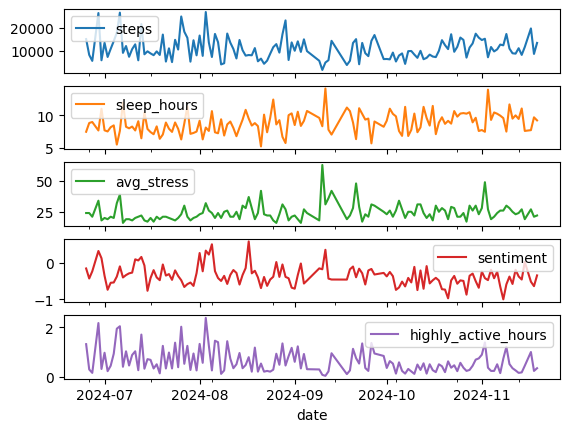

In [357]:
df.plot(x='date', y=['steps', 'sleep_hours', 'avg_stress', 'sentiment', 'highly_active_hours'], subplots=True)
plt.show()

## Plot artists against health metrics

/var/folders/ms/px9tz7h12yz1zq93xb0hzk8h0000gn/T/ipykernel_50633/4110699171.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['main_artist'] = df_top.apply(pick_first_top_artist, axis=1)


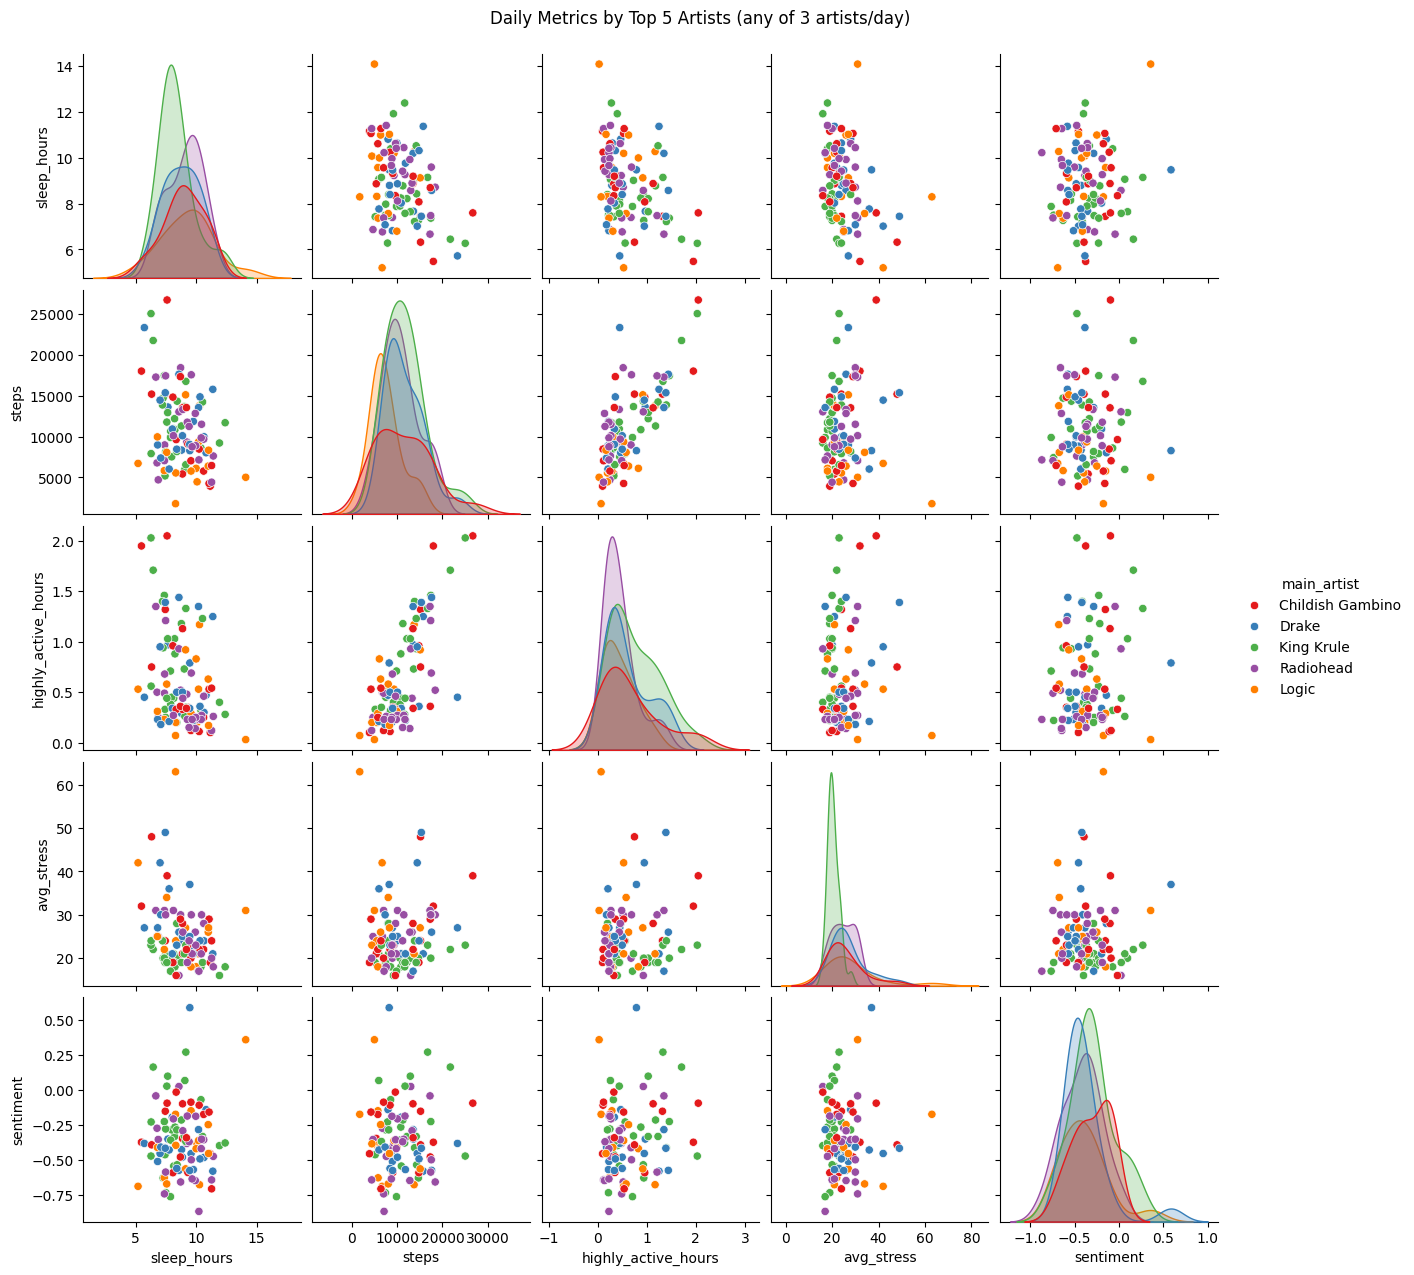

In [358]:
top_artists = pd.concat([df['artist1'], df['artist2'], df['artist3']]).value_counts().head(5).index

df_top = df[
    df[['artist1', 'artist2', 'artist3']].apply(
        lambda row: any(artist in top_artists for artist in row), axis=1
    )
]

def pick_first_top_artist(row):
    for artist in row[['artist1', 'artist2', 'artist3']]:
        if artist in top_artists:
            return artist
    return None

df_top['main_artist'] = df_top.apply(pick_first_top_artist, axis=1)
features = ['sleep_hours', 'steps', 'highly_active_hours', 'avg_stress', 'sentiment']

sns.pairplot(df_top[features + ['main_artist']], hue='main_artist', palette='Set1')
plt.suptitle("Daily Metrics by Top 5 Artists (any of 3 artists/day)", y=1.02)
plt.show()

## Kmeans

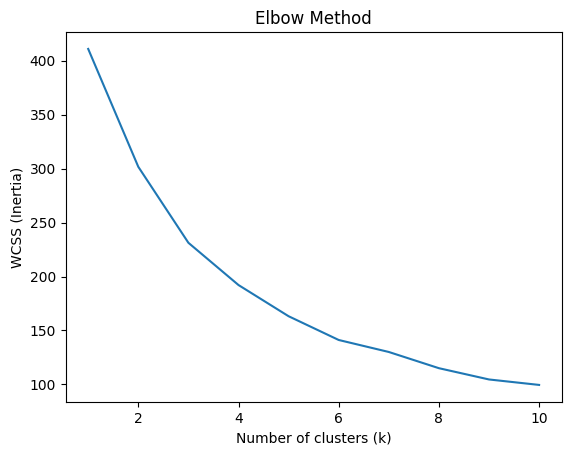

In [370]:
kmeans_df = df[['sleep_hours', 'steps', 'sentiment']]

# Standardize data
scaler = StandardScaler()
kmeans_scaled = scaler.fit_transform(kmeans_df)

# Test different k values
wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, init='random')
    kmeans.fit(kmeans_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.show()


Cluster centers: [[ 1.03627198 -0.6463226   0.39018162]
 [-0.32665982 -0.07308653 -0.52393284]
 [-0.86973548  1.40903389  0.927632  ]]


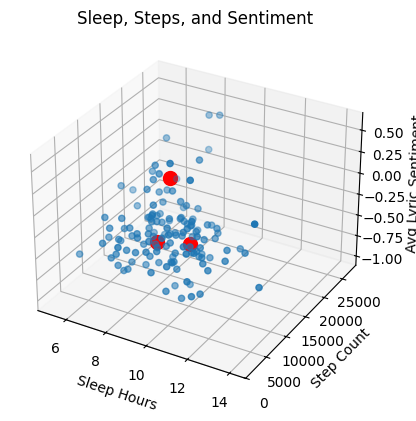

In [394]:
kmeans = KMeans(n_clusters=3, init='random')
kmeans.fit(kmeans_scaled)
print(f'Cluster centers: {kmeans.cluster_centers_}')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Sleep, Steps, and Sentiment')
x = df['sleep_hours']
ax.set_xlabel('Sleep Hours')
y = df['steps']
ax.set_ylabel('Step Count')
z = df['sentiment']
ax.set_zlabel('Avg Lyric Sentiment')
ax.scatter(x, y, z)

unscaled_centers = scaler.inverse_transform(kmeans.cluster_centers_)
for center in unscaled_centers:
    ax.scatter(center[0], center[1], center[2], color='red', s=100)
